In [61]:
# !git clone https://github.com/perrying/guided-filter-pytorch.git
# !ls -l guided-filter-pytorch

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

In [63]:
sys.path.append('/kaggle/working/guided-filter-pytorch')
from guided_filter import GuidedFilter2d

In [64]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

In [65]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [66]:
class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, smooth=1e-6, weight_dice=0.5, weight_focal=0.5):
        super(DiceFocalLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.focal_loss = FocalLoss(alpha, gamma)
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)
        return self.weight_dice * dice + self.weight_focal * focal

In [67]:
class DeepCrackLoss(nn.Module):
    def __init__(self):
        super(DeepCrackLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=0.75, gamma=1.8, reduction='mean')

    def forward(self, outputs, targets):
        total_loss = 0.0
        for i, output in enumerate(outputs[:-1]):
            target_resized = F.interpolate(targets.float(), size=output.shape[2:], mode='bilinear', align_corners=False)
            alpha_m = 0.5 + 0.1 * i
            total_loss += alpha_m * self.focal_loss(output, target_resized)
        fused_output = outputs[-1]
        target_resized = F.interpolate(targets.float(), size=fused_output.shape[2:], mode='bilinear', align_corners=False)
        total_loss += 1.1 * self.focal_loss(fused_output, target_resized)
        return total_loss

In [68]:
def get_norm_layer(norm_type='batch'):
    if norm_type == 'batch':
        return nn.BatchNorm2d
    raise NotImplementedError('Normalization layer [%s] is not implemented' % norm_type)

def init_net(net, init_type='xavier', init_gain=0.02, gpu_ids=[]):
    if len(gpu_ids) > 0 and torch.cuda.is_available():
        net = net.cuda()
        net = nn.DataParallel(net, gpu_ids)
    return net

In [69]:
!cat /kaggle/working/guided-filter-pytorch/guided_filter.py

import torch
import torch.nn as nn
import torch.nn.functional as F

from boxfilter import boxfilter2d

class GuidedFilter2d(nn.Module):
    def __init__(self, radius: int, eps: float):
        super().__init__()
        self.r = radius
        self.eps = eps

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps)
        else:
            raise NotImplementedError

class FastGuidedFilter2d(GuidedFilter2d):
    """Fast guided filter"""
    def __init__(self, radius: int, eps: float, s: int):
        super().__init__(radius, eps)
        self.s = s

    def forward(self, x, guide):
        if guide.shape[1] == 3:
            return guidedfilter2d_color(guide, x, self.r, self.eps, self.s)
        elif guide.shape[1] == 1:
            return guidedfilter2d_gray(guide, x, self.r, self.eps, self.s)
        else:
   

### upsampling bilinear

In [70]:
# class DeepCrackNet(nn.Module):
#     def __init__(self, in_nc=3, num_classes=1, ngf=64, norm='batch'):  # Sửa num_classes=1
#         super(DeepCrackNet, self).__init__()
#         norm_layer = get_norm_layer(norm_type=norm)
#         self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, num_block=2))
#         self.side_conv1 = nn.Conv2d(ngf, num_classes, kernel_size=1, stride=1, bias=False) # conv 1x1 tao ra side output
#         self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, num_block=2))
#         self.side_conv2 = nn.Conv2d(ngf*2, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, num_block=3))
#         self.side_conv3 = nn.Conv2d(ngf*4, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, num_block=3))
#         self.side_conv4 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)
#         self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, num_block=3))
#         self.side_conv5 = nn.Conv2d(ngf*8, num_classes, kernel_size=1, stride=1, bias=False)
#         self.fuse_conv = nn.Conv2d(num_classes*5, num_classes, kernel_size=1, stride=1, bias=False)
#         self.maxpool = nn.MaxPool2d(2, stride=2)
#         self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

#     def _conv_block(self, in_nc, out_nc, norm_layer, num_block=2, kernel_size=3, stride=1, padding=1, bias=False):
#         conv = []
#         for i in range(num_block):
#             cur_in_nc = in_nc if i == 0 else out_nc
#             conv += [nn.Conv2d(cur_in_nc, out_nc, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
#                      norm_layer(out_nc),
#                      nn.ReLU(True)]
#         return conv

#     def forward(self, x):
#         h, w = x.size()[2:]
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(self.maxpool(conv1))
#         conv3 = self.conv3(self.maxpool(conv2))
#         conv4 = self.conv4(self.maxpool(conv3))
#         conv5 = self.conv5(self.maxpool(conv4))
#         side_output1 = self.side_conv1(conv1)
#         side_output2 = self.side_conv2(conv2)
#         side_output3 = self.side_conv3(conv3)
#         side_output4 = self.side_conv4(conv4)
#         side_output5 = self.side_conv5(conv5)
#         side_output2 = F.interpolate(side_output2, size=(h, w), mode='bilinear', align_corners=True)
#         side_output3 = F.interpolate(side_output3, size=(h, w), mode='bilinear', align_corners=True)
#         side_output4 = F.interpolate(side_output4, size=(h, w), mode='bilinear', align_corners=True)
#         side_output5 = F.interpolate(side_output5, size=(h, w), mode='bilinear', align_corners=True)
#         fused = self.fuse_conv(torch.cat([side_output1, side_output2, side_output3, side_output4, side_output5], dim=1))
#         guide = side_output1  # Sử dụng toàn bộ side_output1 làm guidance
#         guided_fused = self.guided_filter(fused, guide)
#         if self.training:
#             return [side_output1, side_output2, side_output3, side_output4, side_output5, guided_fused]
#         else:
#             prob = torch.sigmoid(guided_fused)  # Sử dụng sigmoid cho nhị phân
#             return prob

### upsampling tranpose conv

In [71]:
class DeepCrackNet(nn.Module):
    def __init__(self, in_nc=3, num_classes=1, ngf=64, norm='batch'):
        super(DeepCrackNet, self).__init__()
        norm_layer = get_norm_layer(norm_type=norm)
        
        self.conv1 = nn.Sequential(*self._conv_block(in_nc, ngf, norm_layer, num_block=2))
        self.conv2 = nn.Sequential(*self._conv_block(ngf, ngf*2, norm_layer, num_block=2))
        self.conv3 = nn.Sequential(*self._conv_block(ngf*2, ngf*4, norm_layer, num_block=3))
        self.conv4 = nn.Sequential(*self._conv_block(ngf*4, ngf*8, norm_layer, num_block=3))
        self.conv5 = nn.Sequential(*self._conv_block(ngf*8, ngf*8, norm_layer, num_block=3))
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
        self.side_conv1 = nn.Conv2d(ngf, num_classes, 1)
        self.side_conv2 = nn.Conv2d(ngf*2, num_classes, 1)
        self.side_conv3 = nn.Conv2d(ngf*4, num_classes, 1)
        self.side_conv4 = nn.Conv2d(ngf*8, num_classes, 1)
        self.side_conv5 = nn.Conv2d(ngf*8, num_classes, 1)

        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def _conv_block(self, in_nc, out_nc, norm_layer, num_block=2):
        conv = []
        for i in range(num_block):
            cur_in_nc = in_nc if i == 0 else out_nc
            conv += [nn.Conv2d(cur_in_nc, out_nc, kernel_size=3, padding=1, bias=False), norm_layer(out_nc), nn.ReLU(True)]
        return conv

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.maxpool(conv1))
        conv3 = self.conv3(self.maxpool(conv2))
        conv4 = self.conv4(self.maxpool(conv3))
        conv5 = self.conv5(self.maxpool(conv4))

        side1 = F.interpolate(self.side_conv1(conv1), size=x.shape[2:], mode='bilinear', align_corners=False)
        side2 = F.interpolate(self.side_conv2(conv2), size=x.shape[2:], mode='bilinear', align_corners=False)
        side3 = F.interpolate(self.side_conv3(conv3), size=x.shape[2:], mode='bilinear', align_corners=False)
        side4 = F.interpolate(self.side_conv4(conv4), size=x.shape[2:], mode='bilinear', align_corners=False)
        side5 = F.interpolate(self.side_conv5(conv5), size=x.shape[2:], mode='bilinear', align_corners=False)
        
        fused = self.fuse_conv(torch.cat([side1, side2, side3, side4, side5], dim=1))
        
        # NOTE: Sửa lỗi "bug-as-a-feature" Guided Filter
        # Original paper/code dùng side-output đầu tiên làm guide.
        # Guide và input cho guided_filter phải cùng kích thước.
        # Ở đây, 'fused' và 'side1' đã được upsample về cùng size ảnh gốc, nên code này đúng.
        guided_fused = self.guided_filter(fused, side1)

        return [side1, side2, side3, side4, side5, guided_fused]

In [72]:
# image_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# mask_transform = transforms.Compose([
#     transforms.Resize((224, 224), interpolation=Image.NEAREST),
#     transforms.ToTensor()
# ])

In [73]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)
        return image, (mask > 0.5).float()

In [74]:
image_transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((448, 448), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [75]:
BATCH_SIZE = 8
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [76]:
def calculate_metrics(outputs, labels, criterion, is_deep_supervision):
    if is_deep_supervision:
        loss = criterion(outputs, labels)
        final_output = outputs[-1]
    else:
        # NOTE: Các loss như BCE, Dice, DiceFocal chỉ làm việc với output cuối cùng.
        #       Model DeepCrackNet trả về một list, nên ta lấy phần tử cuối.
        final_output = outputs[-1]
        loss = criterion(final_output, labels)
        
    preds = torch.sigmoid(final_output) > 0.5
    intersection = (preds.bool() & labels.bool()).float().sum()
    union = (preds.bool() | labels.bool()).float().sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    return loss, iou.item()

In [77]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, experiment_name):
    # NOTE: Đã thêm tham số 'experiment_name' để khắc phục lỗi 'TypeError'.
    #       'is_deep_supervision' dùng để phân biệt cách tính loss.
    is_deep_supervision = isinstance(criterion, DeepCrackLoss)
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}
    best_val_iou = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_train_iou = 0.0, 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss, iou = calculate_metrics(outputs, labels, criterion, is_deep_supervision)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_iou += iou
            train_pbar.set_postfix(loss=loss.item(), iou=iou)
        history['train_loss'].append(total_train_loss / len(train_loader))
        history['train_iou'].append(total_train_iou / len(train_loader))

        model.eval()
        total_val_loss, total_val_iou = 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss, iou = calculate_metrics(outputs, labels, criterion, is_deep_supervision)
                total_val_loss += loss.item()
                total_val_iou += iou
                val_pbar.set_postfix(loss=loss.item(), iou=iou)
        history['val_loss'].append(total_val_loss / len(val_loader))
        history['val_iou'].append(total_val_iou / len(val_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {history['train_loss'][-1]:.4f}, Train IoU: {history['train_iou'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}, Val IoU: {history['val_iou'][-1]:.4f}")
        
        if history['val_iou'][-1] > best_val_iou:
            best_val_iou = history['val_iou'][-1]
            # NOTE: Sử dụng 'experiment_name' để lưu file, đảm bảo tính nhất quán.
            torch.save(model.state_dict(), f'best_model_{experiment_name}.pth')
            print(f"** New best model saved with Val IoU: {best_val_iou:.4f} **")
            
    return history

In [78]:
def plot_history(history, experiment_name):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Training History: {experiment_name}', fontsize=16)
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('IoU vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('IoU'); plt.legend(); plt.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [79]:
def visualize_results(model, data_loader, device, experiment_name, num_images=3):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(data_loader))
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        final_output = outputs[-1]
        preds = (torch.sigmoid(final_output) > 0.5).cpu()
        
        plt.figure(figsize=(12, 4 * min(num_images, len(images))))
        plt.suptitle(f"Prediction Results: {experiment_name}", fontsize=16)
        
        inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
        
        for i in range(min(num_images, len(images))):
            img_display = inv_norm(images[i].cpu()).permute(1, 2, 0).clamp(0, 1)
            plt.subplot(min(num_images, len(images)), 3, i * 3 + 1)
            plt.imshow(img_display); plt.title('Input Image'); plt.axis('off')
            plt.subplot(min(num_images, len(images)), 3, i * 3 + 2)
            plt.imshow(labels[i].cpu().squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')
            plt.subplot(min(num_images, len(images)), 3, i * 3 + 3)
            plt.imshow(preds[i].squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

Using device: cuda

==================== TRAINING WITH BCE LOSS ====================


Epoch 1/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.33, loss=0.112]  


Epoch 1/10 -> Train Loss: 0.1526, Train IoU: 0.3407 | Val Loss: 0.0942, Val IoU: 0.3938
** New best model saved with Val IoU: 0.3938 **


Epoch 2/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s, iou=0.256, loss=0.0772]


Epoch 2/10 -> Train Loss: 0.0688, Train IoU: 0.4228 | Val Loss: 0.0651, Val IoU: 0.3511


Epoch 3/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s, iou=0.354, loss=0.0734]


Epoch 3/10 -> Train Loss: 0.0586, Train IoU: 0.4492 | Val Loss: 0.0606, Val IoU: 0.4029
** New best model saved with Val IoU: 0.4029 **


Epoch 4/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.215, loss=0.0974]


Epoch 4/10 -> Train Loss: 0.0524, Train IoU: 0.4773 | Val Loss: 0.0654, Val IoU: 0.3368


Epoch 5/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.166, loss=0.113]  


Epoch 5/10 -> Train Loss: 0.0482, Train IoU: 0.5010 | Val Loss: 0.0681, Val IoU: 0.3675


Epoch 6/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.394, loss=0.0617]


Epoch 6/10 -> Train Loss: 0.0448, Train IoU: 0.5165 | Val Loss: 0.0527, Val IoU: 0.4665
** New best model saved with Val IoU: 0.4665 **


Epoch 7/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.345, loss=0.0584]


Epoch 7/10 -> Train Loss: 0.0427, Train IoU: 0.5315 | Val Loss: 0.0533, Val IoU: 0.3686


Epoch 8/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.39, loss=0.055]  


Epoch 8/10 -> Train Loss: 0.0439, Train IoU: 0.5209 | Val Loss: 0.0479, Val IoU: 0.4110


Epoch 9/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.414, loss=0.058] 


Epoch 9/10 -> Train Loss: 0.0415, Train IoU: 0.5349 | Val Loss: 0.0470, Val IoU: 0.4475


Epoch 10/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s, iou=0.417, loss=0.0564]


Epoch 10/10 -> Train Loss: 0.0406, Train IoU: 0.5459 | Val Loss: 0.0485, Val IoU: 0.4329


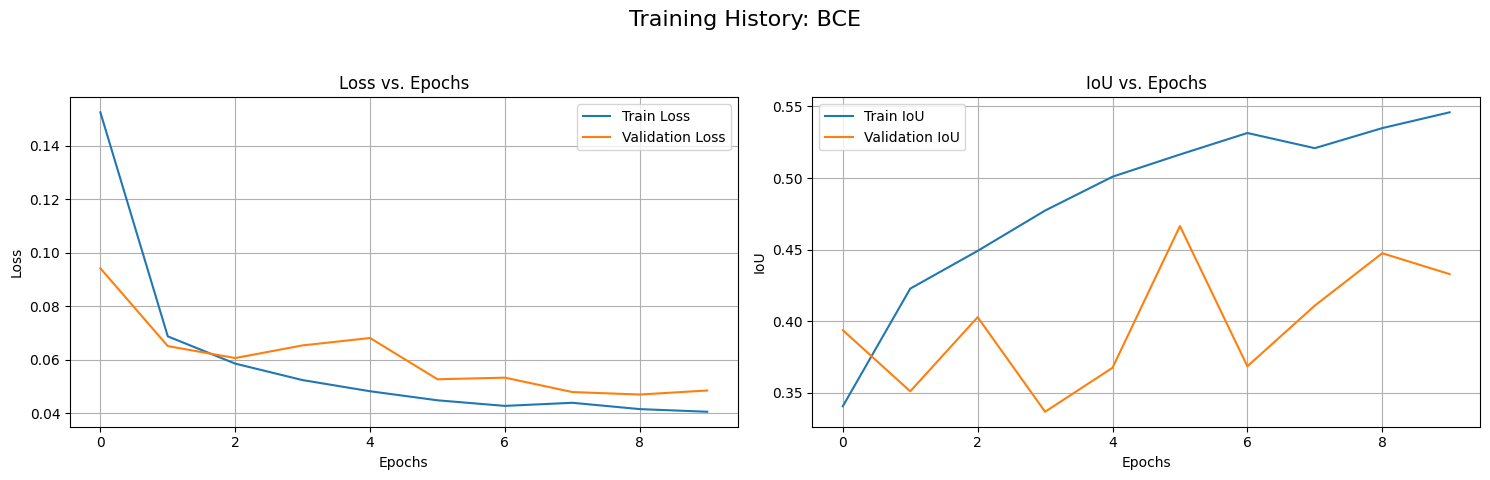

--- Visualizing results for BCE loss ---
Loading best saved model from: best_model_BCE.pth


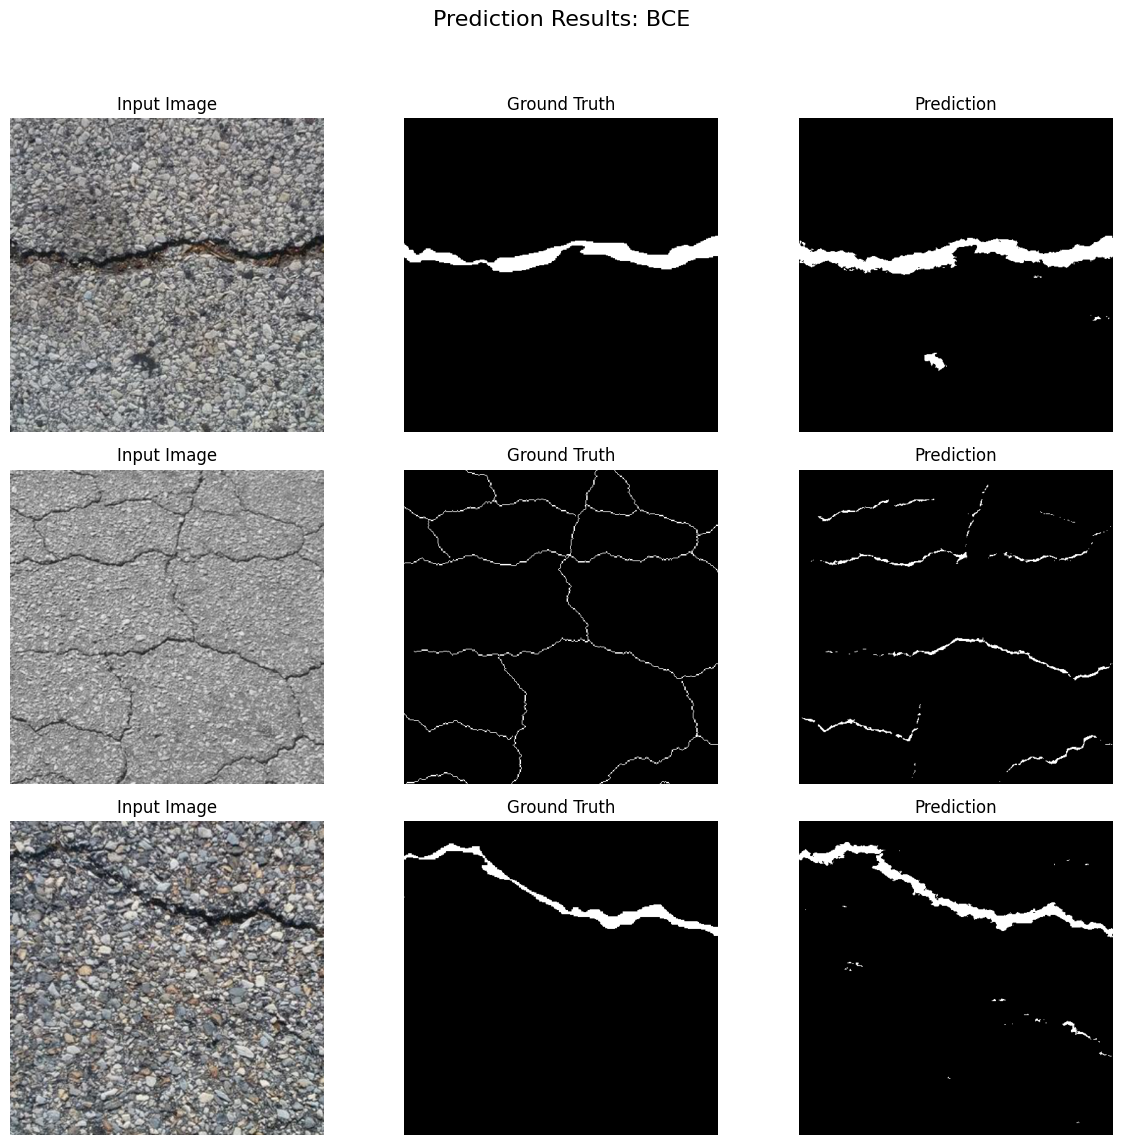


==================== TRAINING WITH Dice LOSS ====================


Epoch 1/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s, iou=0.335, loss=0.561]


Epoch 1/10 -> Train Loss: 0.6151, Train IoU: 0.3523 | Val Loss: 0.4943, Val IoU: 0.4158
** New best model saved with Val IoU: 0.4158 **


Epoch 2/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.358, loss=0.493]


Epoch 2/10 -> Train Loss: 0.3914, Train IoU: 0.4906 | Val Loss: 0.4205, Val IoU: 0.4424
** New best model saved with Val IoU: 0.4424 **


Epoch 3/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.353, loss=0.489]


Epoch 3/10 -> Train Loss: 0.3438, Train IoU: 0.5210 | Val Loss: 0.3976, Val IoU: 0.4569
** New best model saved with Val IoU: 0.4569 **


Epoch 4/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s, iou=0.363, loss=0.481]


Epoch 4/10 -> Train Loss: 0.3327, Train IoU: 0.5267 | Val Loss: 0.3953, Val IoU: 0.4618
** New best model saved with Val IoU: 0.4618 **


Epoch 5/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.42, loss=0.418] 


Epoch 5/10 -> Train Loss: 0.3189, Train IoU: 0.5394 | Val Loss: 0.3989, Val IoU: 0.4495


Epoch 6/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s, iou=0.421, loss=0.424]


Epoch 6/10 -> Train Loss: 0.3203, Train IoU: 0.5365 | Val Loss: 0.4279, Val IoU: 0.4234


Epoch 7/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.03it/s, iou=0.39, loss=0.445] 


Epoch 7/10 -> Train Loss: 0.3063, Train IoU: 0.5511 | Val Loss: 0.3612, Val IoU: 0.4874
** New best model saved with Val IoU: 0.4874 **


Epoch 8/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.421, loss=0.413]


Epoch 8/10 -> Train Loss: 0.2928, Train IoU: 0.5644 | Val Loss: 0.3845, Val IoU: 0.4628


Epoch 9/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s, iou=0.418, loss=0.418]


Epoch 9/10 -> Train Loss: 0.3029, Train IoU: 0.5534 | Val Loss: 0.3542, Val IoU: 0.4956
** New best model saved with Val IoU: 0.4956 **


Epoch 10/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.415, loss=0.417]


Epoch 10/10 -> Train Loss: 0.2956, Train IoU: 0.5603 | Val Loss: 0.3567, Val IoU: 0.4897


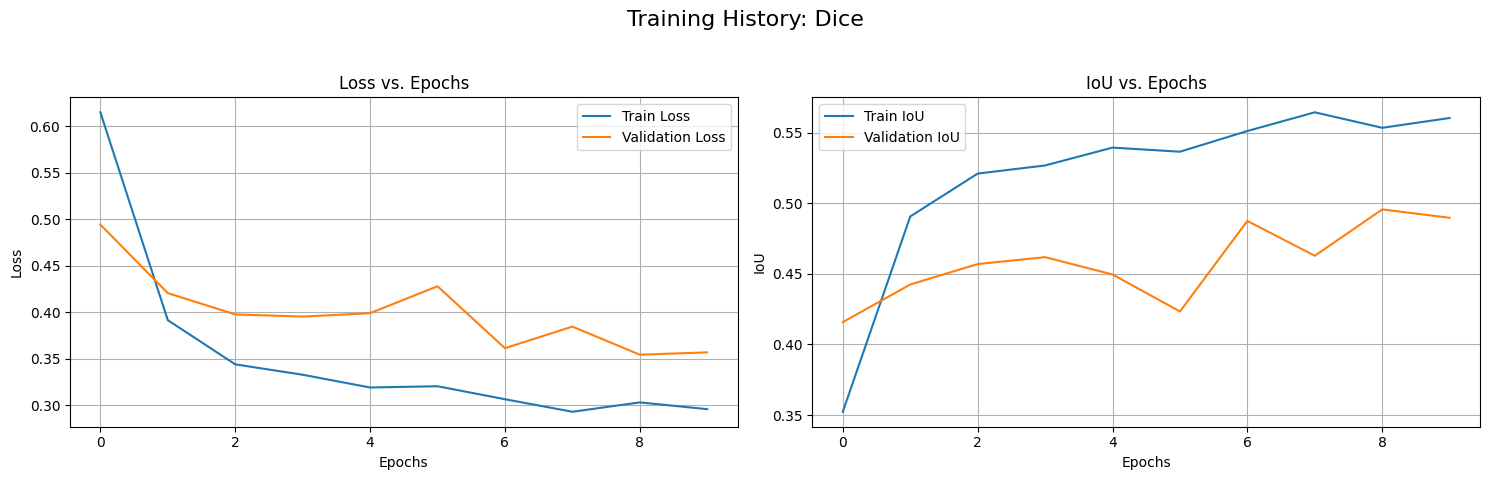

--- Visualizing results for Dice loss ---
Loading best saved model from: best_model_Dice.pth


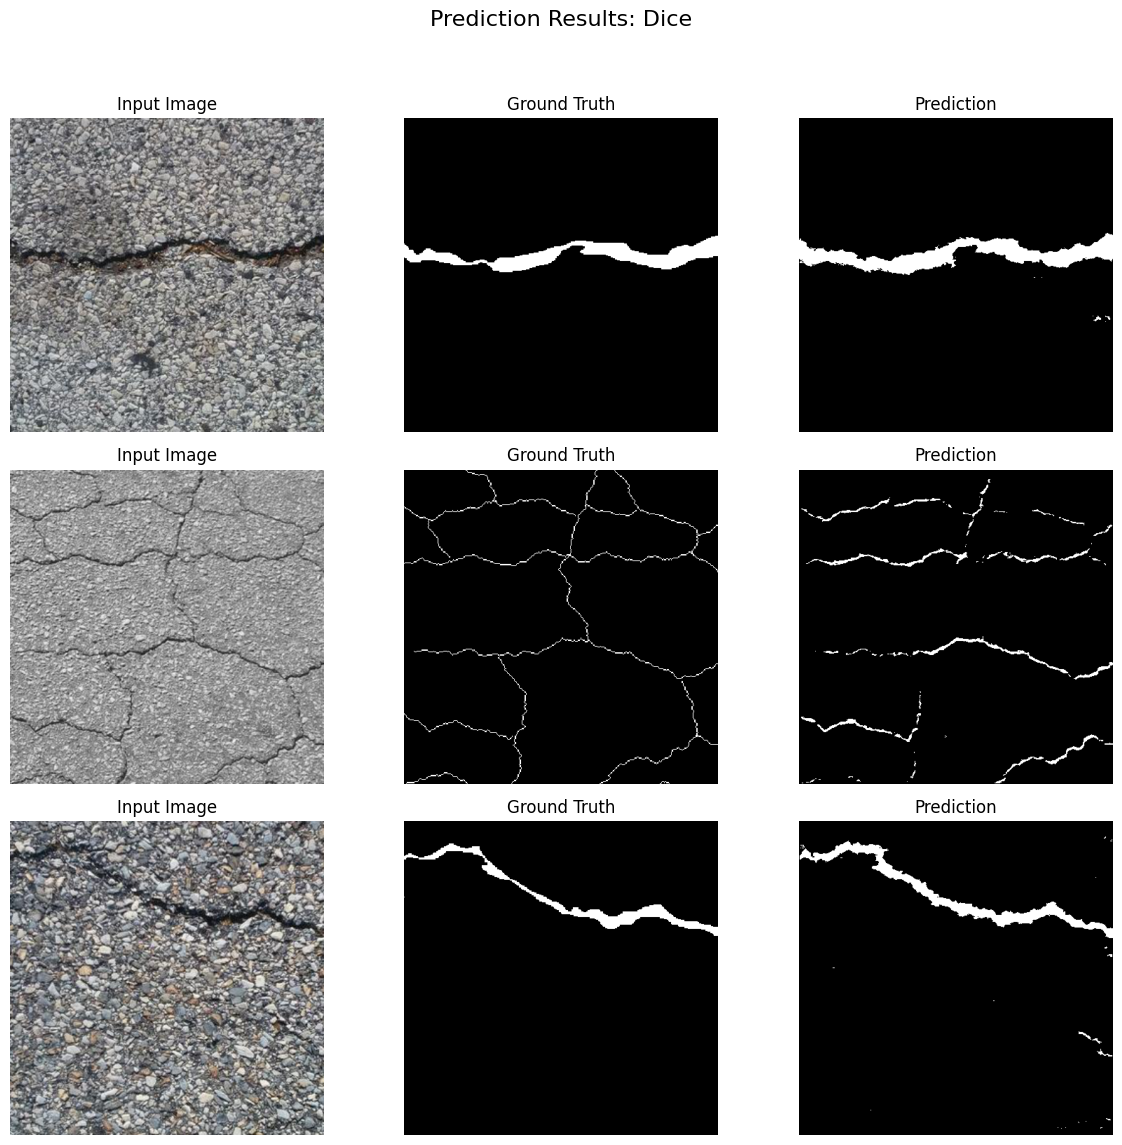


==================== TRAINING WITH DiceFocal LOSS ====================


Epoch 1/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.04it/s, iou=0.338, loss=0.377]


Epoch 1/10 -> Train Loss: 0.4270, Train IoU: 0.3523 | Val Loss: 0.3570, Val IoU: 0.3994
** New best model saved with Val IoU: 0.3994 **


Epoch 2/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.05it/s, iou=0.357, loss=0.296]


Epoch 2/10 -> Train Loss: 0.2746, Train IoU: 0.4694 | Val Loss: 0.2644, Val IoU: 0.4314
** New best model saved with Val IoU: 0.4314 **


Epoch 3/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s, iou=0.367, loss=0.274]


Epoch 3/10 -> Train Loss: 0.2165, Train IoU: 0.5056 | Val Loss: 0.2347, Val IoU: 0.4524
** New best model saved with Val IoU: 0.4524 **


Epoch 4/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s, iou=0.354, loss=0.284]


Epoch 4/10 -> Train Loss: 0.2001, Train IoU: 0.5212 | Val Loss: 0.2255, Val IoU: 0.4680
** New best model saved with Val IoU: 0.4680 **


Epoch 5/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.389, loss=0.258]


Epoch 5/10 -> Train Loss: 0.1876, Train IoU: 0.5411 | Val Loss: 0.2133, Val IoU: 0.4825
** New best model saved with Val IoU: 0.4825 **


Epoch 6/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.01it/s, iou=0.39, loss=0.258] 


Epoch 6/10 -> Train Loss: 0.1832, Train IoU: 0.5461 | Val Loss: 0.2163, Val IoU: 0.4768


Epoch 7/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s, iou=0.381, loss=0.262]


Epoch 7/10 -> Train Loss: 0.1850, Train IoU: 0.5424 | Val Loss: 0.2138, Val IoU: 0.4811


Epoch 8/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.376, loss=0.269]


Epoch 8/10 -> Train Loss: 0.1785, Train IoU: 0.5534 | Val Loss: 0.2093, Val IoU: 0.4907
** New best model saved with Val IoU: 0.4907 **


Epoch 9/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s, iou=0.399, loss=0.251]


Epoch 9/10 -> Train Loss: 0.1737, Train IoU: 0.5609 | Val Loss: 0.2051, Val IoU: 0.4936
** New best model saved with Val IoU: 0.4936 **


Epoch 10/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.02it/s, iou=0.256, loss=0.338]


Epoch 10/10 -> Train Loss: 0.1698, Train IoU: 0.5688 | Val Loss: 0.2313, Val IoU: 0.4521


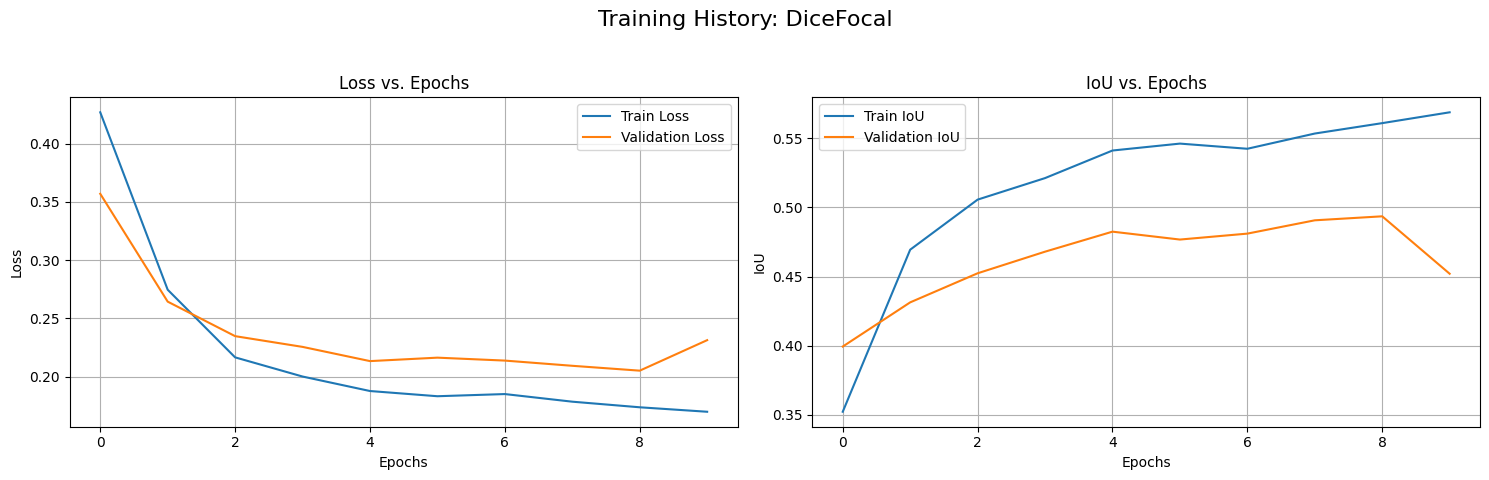

--- Visualizing results for DiceFocal loss ---
Loading best saved model from: best_model_DiceFocal.pth


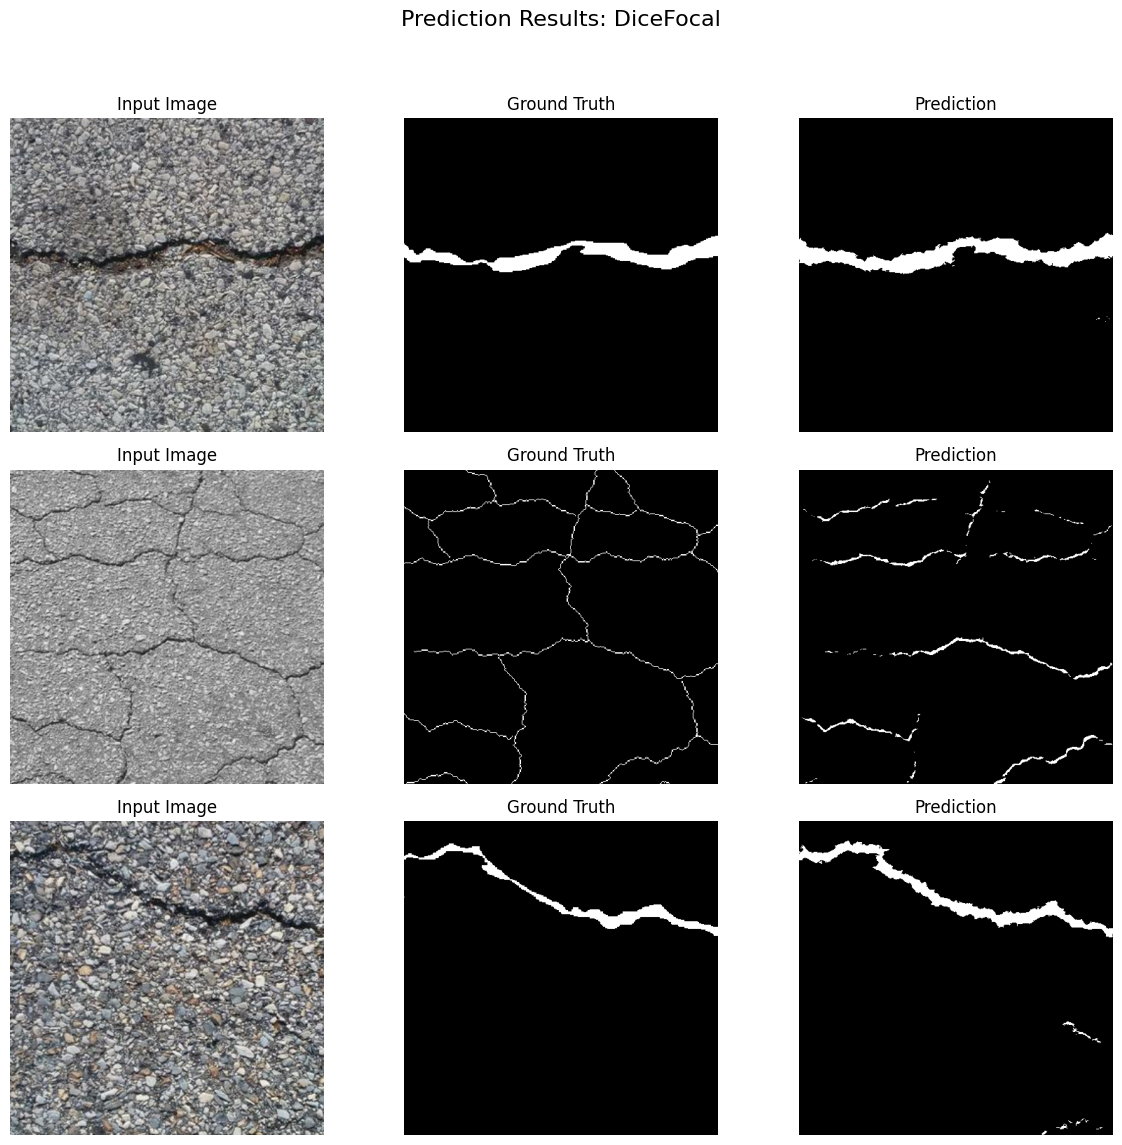


==================== TRAINING WITH DeepCrack LOSS ====================


Epoch 1/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s, iou=0.322, loss=0.182] 


Epoch 1/10 -> Train Loss: 0.2700, Train IoU: 0.3281 | Val Loss: 0.1624, Val IoU: 0.3042
** New best model saved with Val IoU: 0.3042 **


Epoch 2/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s, iou=0.338, loss=0.121] 


Epoch 2/10 -> Train Loss: 0.1226, Train IoU: 0.3169 | Val Loss: 0.1110, Val IoU: 0.3639
** New best model saved with Val IoU: 0.3639 **


Epoch 3/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s, iou=0.303, loss=0.0999] 


Epoch 3/10 -> Train Loss: 0.0944, Train IoU: 0.3359 | Val Loss: 0.0919, Val IoU: 0.2464


Epoch 4/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s, iou=0.355, loss=0.094] 


Epoch 4/10 -> Train Loss: 0.0826, Train IoU: 0.3216 | Val Loss: 0.0822, Val IoU: 0.3359


Epoch 5/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.96it/s, iou=0.364, loss=0.0843]


Epoch 5/10 -> Train Loss: 0.0736, Train IoU: 0.3583 | Val Loss: 0.0753, Val IoU: 0.3526


Epoch 6/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s, iou=0.364, loss=0.0833]


Epoch 6/10 -> Train Loss: 0.0698, Train IoU: 0.3646 | Val Loss: 0.0726, Val IoU: 0.3573


Epoch 7/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s, iou=0.319, loss=0.0796]


Epoch 7/10 -> Train Loss: 0.0665, Train IoU: 0.3691 | Val Loss: 0.0733, Val IoU: 0.2471


Epoch 8/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s, iou=0.376, loss=0.0765]


Epoch 8/10 -> Train Loss: 0.0632, Train IoU: 0.3946 | Val Loss: 0.0680, Val IoU: 0.3806
** New best model saved with Val IoU: 0.3806 **


Epoch 9/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s, iou=0.383, loss=0.0753]


Epoch 9/10 -> Train Loss: 0.0620, Train IoU: 0.3998 | Val Loss: 0.0686, Val IoU: 0.3764


Epoch 10/10 [Val]: 100%|██████████| 50/50 [00:12<00:00,  3.97it/s, iou=0.373, loss=0.0787]


Epoch 10/10 -> Train Loss: 0.0617, Train IoU: 0.3927 | Val Loss: 0.0688, Val IoU: 0.3773


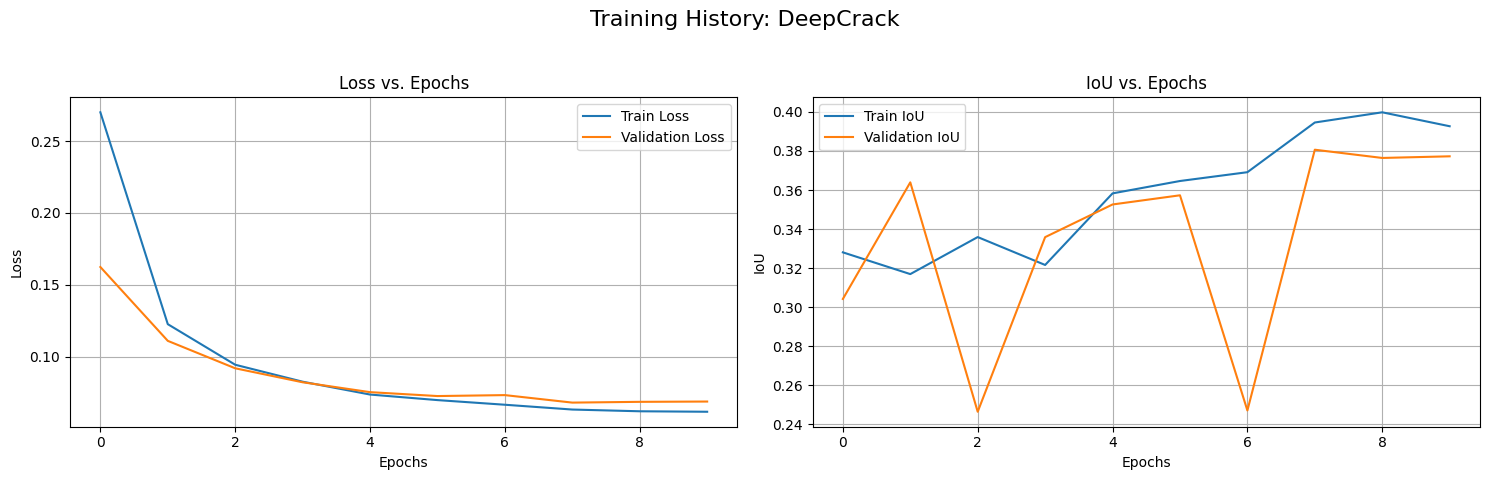

--- Visualizing results for DeepCrack loss ---
Loading best saved model from: best_model_DeepCrack.pth


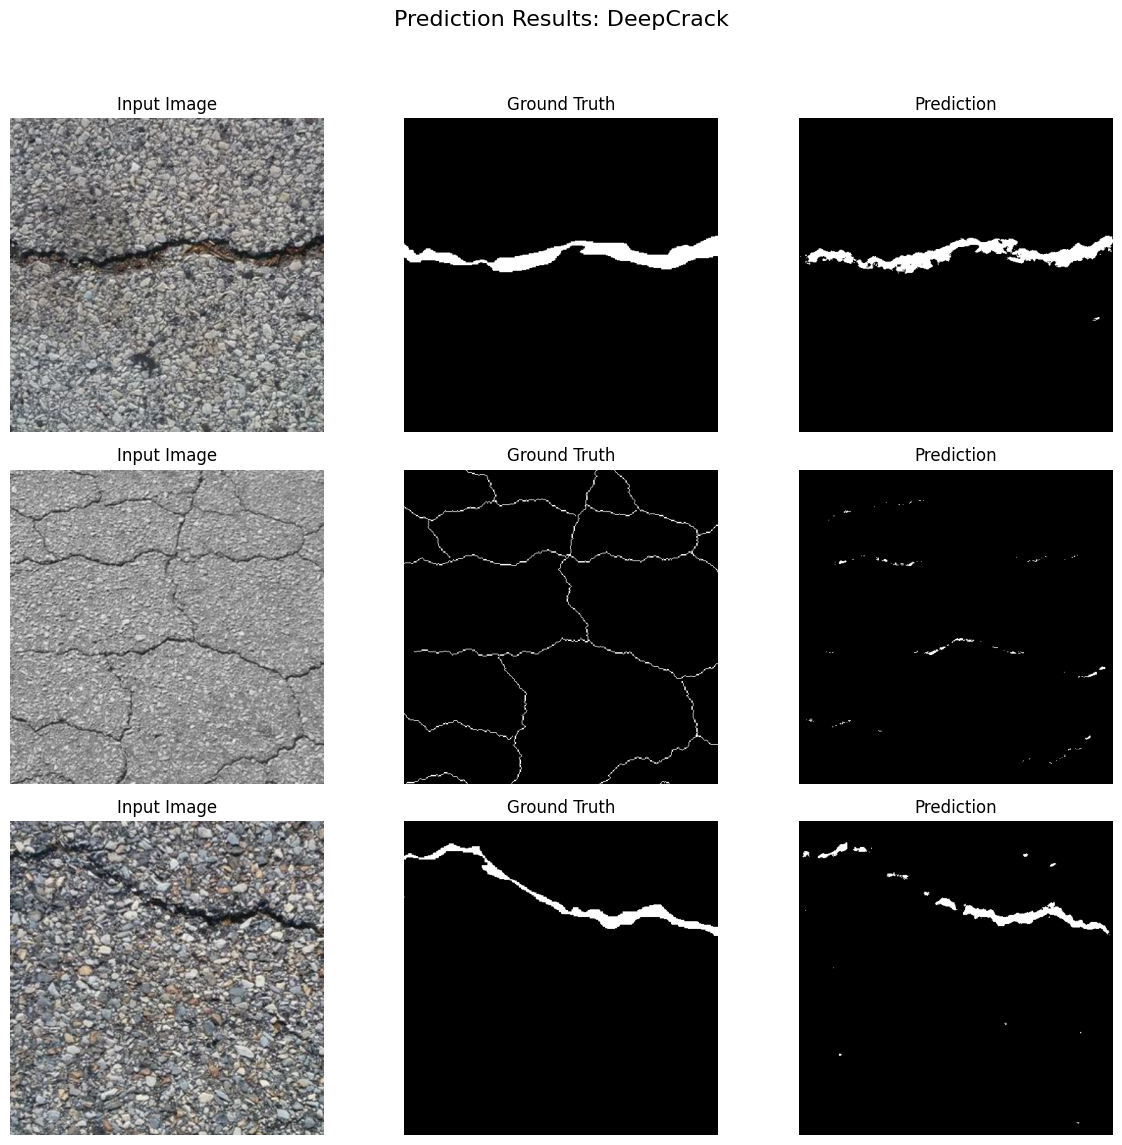



All experiments finished.


In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# NOTE: Thêm BCE vào danh sách các hàm loss cần thử nghiệm.
loss_functions = {
    "BCE": nn.BCEWithLogitsLoss(),
    "Dice": DiceLoss(),
    "DiceFocal": DiceFocalLoss(),
    "DeepCrack": DeepCrackLoss(),
}

NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

for name, criterion in loss_functions.items():
    print(f"\n{'='*20} TRAINING WITH {name} LOSS {'='*20}")
    
    model = DeepCrackNet().to(device) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    
    # NOTE: Đảm bảo truyền 'name' vào làm tham số 'experiment_name'
    history = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion.to(device), NUM_EPOCHS, device, name)
    
    plot_history(history, name)
    
    print(f"--- Visualizing results for {name} loss ---")
    best_model_path = f'best_model_{name}.pth'

    # NOTE: Khối code này khắc phục lỗi 'FileNotFoundError'.
    # Nó kiểm tra xem file có tồn tại không trước khi tải.
    if os.path.exists(best_model_path):
        print(f"Loading best saved model from: {best_model_path}")
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    else:
        print(f"Warning: No best model was saved for '{name}' loss because performance did not improve.")
        print("Visualizing model from the last training epoch instead.")
        # Không cần làm gì, 'model' đã ở trạng thái cuối cùng của quá trình training.

    visualize_results(model, val_loader, device, name)

print("\n\nAll experiments finished.")